In [1]:
# let's see what is in labels file

import pandas as pd
from cv2 import cv2
import matplotlib.pyplot as plt  # plot
import os
from os.path import join

path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


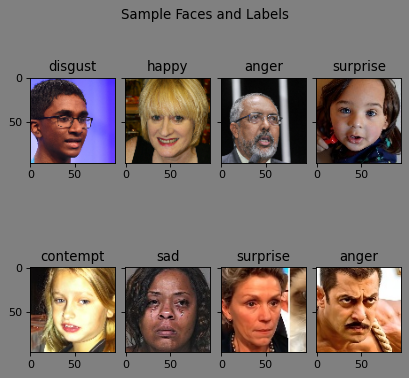

In [2]:
# display random images

import random

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(5, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()

for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])

In [3]:
# how many emotions categories

import os

INPUT_PATH = "/kaggle/input/affectnet-training-data/"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96, 96)

print(EMOTIONS)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


In [4]:
# define functions to pre-process and load images into arrays

import cv2
import numpy as np
from keras.utils import to_categorical
import os

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            #img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

In [5]:
# Load the images
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
#input_shape = (96,96,1) 

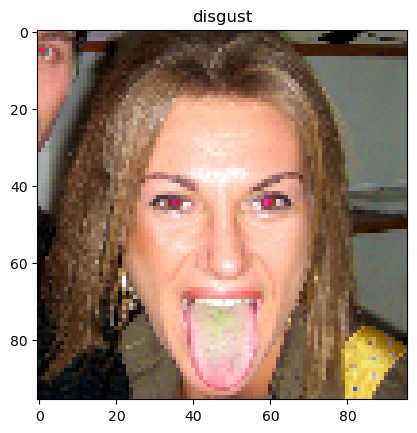

In [6]:
import matplotlib.pyplot as plt

# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.show()

In [7]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# # create a stratified train-test split
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# for train_index, test_index in split.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# Model_2

In [8]:
# our updated model

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(256, activation='selu', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation='softmax'))

model_2.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_2.fit(X_train, y_train, batch_size=64,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
364/364 [==============================] - 13s 20ms/step - loss: 3.9891 - accuracy: 0.4477 - val_loss: 2.8853 - val_accuracy: 0.4175 - lr: 0.0010
Epoch 2/25
364/364 [==============================] - 7s 19ms/step - loss: 2.2510 - accuracy: 0.5332 - val_loss: 3.0582 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 3/25
364/364 [==============================] - 7s 19ms/step - loss: 2.0596 - accuracy: 0.5594 - val_loss: 1.9636 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 4/25
364/364 [==============================] - 7s 19ms/step - loss: 1.9844 - accuracy: 0.5775 - val_loss: 2.2942 - val_accuracy: 0.4818 - lr: 0.0010
Epoch 5/25
361/364 [============================>.] - ETA: 0s - loss: 1.9710 - accuracy: 0.5851
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
364/364 [==============================] - 7s 19ms/step - loss: 1.9705 - accuracy: 0.5852 - val_loss: 2.0532 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 6/25
364/364 [==============================] - 7s 

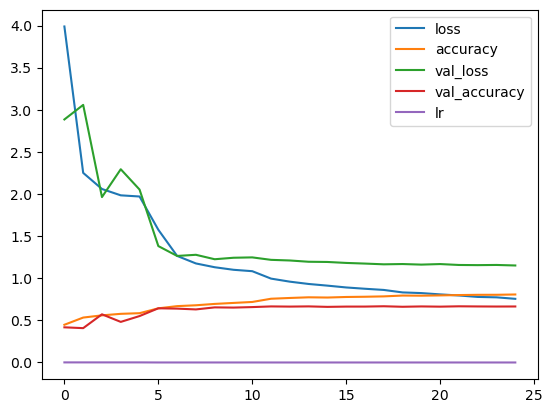

In [10]:
pd.DataFrame(history.history).plot();

In [11]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_2.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

182/182 [==============================] - 1s 3ms/step
R2 score: 0.44203745445853976


In [12]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_2.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       815
           1       0.62      0.44      0.52       660
           2       0.86      0.88      0.87       982
           3       0.55      0.47      0.51       582
           4       0.48      0.52      0.50       517
           5       0.53      0.73      0.61       578
           6       0.91      0.91      0.91       988
           7       0.58      0.49      0.53       687

    accuracy                           0.66      5809
   macro avg       0.64      0.63      0.63      5809
weighted avg       0.67      0.66      0.66      5809



# Model_3

In [13]:
# our new model_3

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_3 = Sequential()

model_3.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(8, activation='softmax'))

model_3.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 64)      

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_3.fit(X_train, y_train, batch_size=64,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
364/364 [==============================] - 12s 29ms/step - loss: 2.9846 - accuracy: 0.4207 - val_loss: 1.8060 - val_accuracy: 0.5194 - lr: 0.0010
Epoch 2/25
364/364 [==============================] - 10s 29ms/step - loss: 1.5098 - accuracy: 0.5428 - val_loss: 1.3654 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 3/25
364/364 [==============================] - 10s 27ms/step - loss: 1.2230 - accuracy: 0.5889 - val_loss: 1.1800 - val_accuracy: 0.5924 - lr: 0.0010
Epoch 4/25
364/364 [==============================] - 10s 27ms/step - loss: 1.1511 - accuracy: 0.6117 - val_loss: 1.1296 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 5/25
364/364 [==============================] - 10s 29ms/step - loss: 1.1001 - accuracy: 0.6340 - val_loss: 1.1598 - val_accuracy: 0.6206 - lr: 0.0010
Epoch 6/25
363/364 [============================>.] - ETA: 0s - loss: 1.0495 - accuracy: 0.6504
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
364/364 [==============================] -

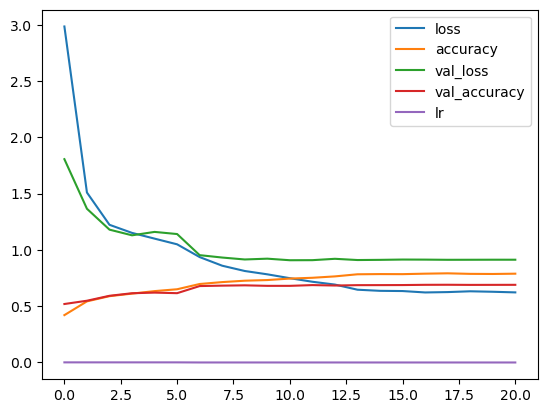

In [15]:
pd.DataFrame(history.history).plot();

In [16]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_3.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

182/182 [==============================] - 1s 5ms/step
R2 score: 0.4756860271472505


In [17]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_3.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       815
           1       0.60      0.52      0.55       660
           2       0.88      0.89      0.88       982
           3       0.51      0.57      0.54       582
           4       0.55      0.54      0.54       517
           5       0.63      0.72      0.67       578
           6       0.92      0.93      0.92       988
           7       0.58      0.52      0.55       687

    accuracy                           0.69      5809
   macro avg       0.66      0.66      0.66      5809
weighted avg       0.69      0.69      0.69      5809



# Model_4

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_4 = Sequential()

model_4.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.3))

model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.4))

model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.5))

model_4.add(Flatten())
model_4.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))
model_4.add(Dense(8, activation='softmax'))

model_4.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 45, 45, 64)      

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_4.fit(X_train, y_train, batch_size=64,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/15
364/364 [==============================] - 12s 28ms/step - loss: 3.2172 - accuracy: 0.3810 - val_loss: 1.9956 - val_accuracy: 0.5061 - lr: 0.0010
Epoch 2/15
364/364 [==============================] - 10s 27ms/step - loss: 1.6580 - accuracy: 0.5240 - val_loss: 1.3866 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 3/15
364/364 [==============================] - 10s 27ms/step - loss: 1.2981 - accuracy: 0.5668 - val_loss: 1.2976 - val_accuracy: 0.5788 - lr: 0.0010
Epoch 4/15
364/364 [==============================] - 10s 27ms/step - loss: 1.1983 - accuracy: 0.5943 - val_loss: 1.2321 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 5/15
364/364 [==============================] - 10s 27ms/step - loss: 1.1502 - accuracy: 0.6125 - val_loss: 1.1024 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 6/15
364/364 [==============================] - 10s 28ms/step - loss: 1.1106 - accuracy: 0.6300 - val_loss: 1.1014 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 7/15
364/364 [==============================] - 10s 

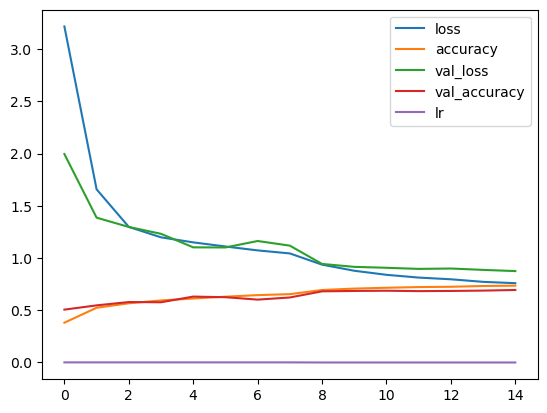

In [20]:
pd.DataFrame(history.history).plot();

In [21]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_4.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

182/182 [==============================] - 1s 4ms/step
R2 score: 0.48885429266422525


In [22]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_4.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       815
           1       0.61      0.54      0.57       660
           2       0.87      0.90      0.88       982
           3       0.55      0.56      0.56       582
           4       0.57      0.48      0.52       517
           5       0.63      0.74      0.68       578
           6       0.94      0.90      0.92       988
           7       0.55      0.56      0.56       687

    accuracy                           0.69      5809
   macro avg       0.67      0.66      0.66      5809
weighted avg       0.69      0.69      0.69      5809



# Model_5

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D, ZeroPadding2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_5 = Sequential()

model_5.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.2))

model_5.add(Conv2D(64, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(Conv2D(64, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.3))

model_5.add(Conv2D(128, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(Conv2D(128, (3,3), activation="selu"))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.4))

model_5.add(Conv2D(256, (3,3), activation="selu", padding='same'))
model_5.add(BatchNormalization())
model_5.add(Conv2D(256, (3,3), activation="selu", padding='same'))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2)))
model_5.add(Dropout(0.5))

model_5.add(ZeroPadding2D(padding=(1, 1)))
model_5.add(Conv2D(512, (3,3), activation="selu", padding='valid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Flatten())
model_5.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))
model_5.add(Dense(8, activation='softmax'))

model_5.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_5.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_20 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 47, 47, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 45, 45, 64)      

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_5.fit(X_train, y_train, batch_size=64,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
364/364 [==============================] - 13s 33ms/step - loss: 3.3328 - accuracy: 0.3867 - val_loss: 1.9432 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 2/25
364/364 [==============================] - 11s 30ms/step - loss: 1.6826 - accuracy: 0.5138 - val_loss: 1.5315 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 3/25
364/364 [==============================] - 11s 30ms/step - loss: 1.5009 - accuracy: 0.5517 - val_loss: 1.5545 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 4/25
364/364 [==============================] - 11s 30ms/step - loss: 1.4110 - accuracy: 0.5731 - val_loss: 1.5084 - val_accuracy: 0.5672 - lr: 0.0010
Epoch 5/25
364/364 [==============================] - 11s 30ms/step - loss: 1.3595 - accuracy: 0.5912 - val_loss: 1.2754 - val_accuracy: 0.6147 - lr: 0.0010
Epoch 6/25
364/364 [==============================] - 11s 32ms/step - loss: 1.2934 - accuracy: 0.6152 - val_loss: 1.3215 - val_accuracy: 0.6004 - lr: 0.0010
Epoch 7/25
363/364 [============================>.] - ETA:

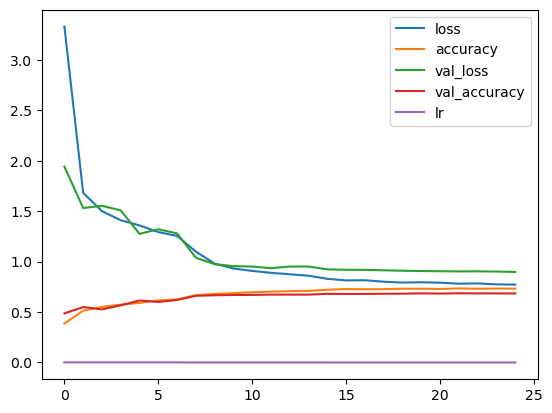

In [25]:
pd.DataFrame(history.history).plot();

In [26]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model_4.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

182/182 [==============================] - 1s 5ms/step
R2 score: 0.48885429266422525


In [27]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_4.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       815
           1       0.61      0.54      0.57       660
           2       0.87      0.90      0.88       982
           3       0.55      0.56      0.56       582
           4       0.57      0.48      0.52       517
           5       0.63      0.74      0.68       578
           6       0.94      0.90      0.92       988
           7       0.55      0.56      0.56       687

    accuracy                           0.69      5809
   macro avg       0.67      0.66      0.66      5809
weighted avg       0.69      0.69      0.69      5809



Not bad for today :)